In [ ]:
import pandas as pd
import numpy as np
import pickle
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from PIL import Image
import os
import cv2

In [ ]:
def ReLU(Z):
    return np.maximum(Z, 0)

def derivative_ReLU(Z):
    return Z > 0

def softmax(Z):
    exp = np.exp(Z - np.max(Z))  
    return exp / exp.sum(axis=0)

In [ ]:
def init_params(dim):
    Layers = len(dim)
    parameters = {}
    for layer in range(1, Layers):
        parameters['W' + str(layer)] = np.random.rand(dim[layer], dim[layer-1]) - 0.5
        parameters['b' + str(layer)] = np.random.rand(dim[layer], 1) - 0.5
    return parameters

def forward_propagation(X, parameters):
    Layers = len(parameters) // 2  
    activations = {'A0': X}
    for layer in range(1, Layers):
        Z = parameters['W' + str(layer)].dot(activations['A' + str(layer-1)]) + parameters['b' + str(layer)]
        A = ReLU(Z)
        activations['Z' + str(layer)] = Z
        activations['A' + str(layer)] = A
    Z_last = parameters['W' + str(Layers)].dot(activations['A' + str(Layers-1)]) + parameters['b' + str(Layers)]
    A_last = softmax(Z_last)
    activations['Z' + str(Layers)] = Z_last
    activations['A' + str(Layers)] = A_last
    return activations

def one_hot(Y):
    one_hot_Y = np.zeros((Y.max()+1,Y.size)) 
    one_hot_Y[Y,np.arange(Y.size)] = 1 
    return one_hot_Y

def backward_propagation(X, Y, activations, parameters, m):
    Layers = len(parameters) // 2  
    one_hot_Y = one_hot(Y)
    dZ = activations['A' + str(Layers)] - one_hot_Y
    gradients = {}
    gradients['dW' + str(Layers)] = 1/m * (dZ.dot(activations['A' + str(Layers-1)].T))
    gradients['db' + str(Layers)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    for layer in reversed(range(1, Layers)):
        dA = parameters['W' + str(layer+1)].T.dot(dZ)
        dZ = dA * derivative_ReLU(activations['Z' + str(layer)])
        gradients['dW' + str(layer)] = 1/m * (dZ.dot(activations['A' + str(layer-1)].T))
        gradients['db' + str(layer)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    return gradients

def update_params(alpha, parameters, gradients):
    Layers = len(parameters) // 2  
    for layer in range(1, Layers + 1):
        parameters['W' + str(layer)] -= alpha * gradients['dW' + str(layer)]
        parameters['b' + str(layer)] -= alpha * gradients['db' + str(layer)]
    return parameters

In [ ]:
def get_predictions(A):
    return np.argmax(A, axis=0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def get_log_loss(A, Y):
    epsilon = 1e-7  
    m = Y.shape[1]
    log_probs = np.log(A + epsilon)
    log_loss = -np.sum(log_probs * Y) / m
    return log_loss

In [116]:
def gradient_descent(X, Y, layer_sizes, alpha, iterations):
    log_loss_history = []
    accuracy_history = []
    size, m = X.shape
    parameters = init_params(layer_sizes)
    for iter in tqdm(range(iterations)):
        activations = forward_propagation(X, parameters)
        gradients = backward_propagation(X, Y, activations, parameters, m)
        parameters = update_params(alpha, parameters, gradients)

        if (iter+1) % int(iterations/10) == 0:
            prediction = get_predictions(activations['A' + str(len(layer_sizes) - 1)])
            accuracy = get_accuracy(prediction, Y)
            log_loss = get_log_loss(activations['A' + str(len(layer_sizes) - 1)], one_hot(Y))
            log_loss_history.append(log_loss)
            accuracy_history.append(accuracy)

            print(f"Iteration: {iter+1} / {iterations}")
            print(f'Log Loss: {log_loss:.3f}')
            print(f'Accuracy: {accuracy:.3%}')
            print('----------------------------')


    plt.figure(figsize=(8, 6))
    plt.plot(log_loss_history, label='Log Loss')
    plt.plot(accuracy_history, label='Accuracy')
    plt.xlabel('Iterations (in tens)')
    plt.ylabel('Value')
    plt.title('Log Loss and Accuracy vs. Iterations')
    plt.legend()
    plt.show()
    return parameters

def make_predictions(X, parameters):
    activations = forward_propagation(X, parameters)
    predictions = get_predictions(activations['A' + str(len(parameters) // 2)])
    return predictions


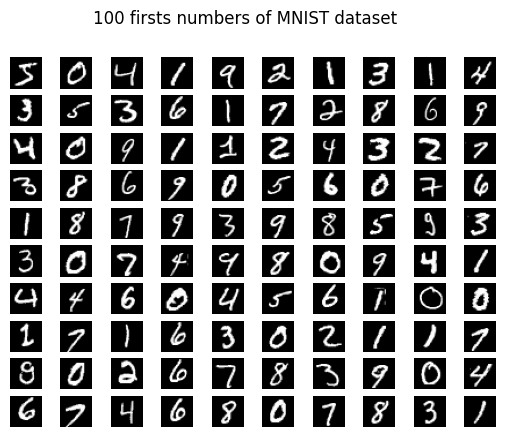

In [148]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.suptitle("100 firsts numbers of MNIST dataset")
plt.show()


SCALE_FACTOR = 255  
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], WIDTH*HEIGHT).T / SCALE_FACTOR
X_test = X_test.reshape(X_test.shape[0], WIDTH*HEIGHT).T / SCALE_FACTOR

 10%|█         | 50/500 [00:49<07:43,  1.03s/it]

Iteration: 50 / 500
Log Loss: 0.898
Accuracy: 70.890%
----------------------------


 20%|██        | 100/500 [01:38<06:49,  1.02s/it]

Iteration: 100 / 500
Log Loss: 0.620
Accuracy: 80.752%
----------------------------


 30%|███       | 150/500 [02:27<06:14,  1.07s/it]

Iteration: 150 / 500
Log Loss: 0.507
Accuracy: 84.530%
----------------------------


 40%|████      | 200/500 [03:17<05:02,  1.01s/it]

Iteration: 200 / 500
Log Loss: 0.442
Accuracy: 86.580%
----------------------------


 50%|█████     | 250/500 [04:02<03:12,  1.30it/s]

Iteration: 250 / 500
Log Loss: 0.399
Accuracy: 87.958%
----------------------------


 60%|██████    | 300/500 [04:42<02:43,  1.22it/s]

Iteration: 300 / 500
Log Loss: 0.365
Accuracy: 89.025%
----------------------------


 70%|███████   | 350/500 [05:22<01:59,  1.26it/s]

Iteration: 350 / 500
Log Loss: 0.339
Accuracy: 89.740%
----------------------------


 80%|████████  | 400/500 [05:57<00:57,  1.73it/s]

Iteration: 400 / 500
Log Loss: 0.317
Accuracy: 90.312%
----------------------------


 90%|█████████ | 450/500 [06:29<00:40,  1.23it/s]

Iteration: 450 / 500
Log Loss: 0.297
Accuracy: 90.912%
----------------------------


100%|██████████| 500/500 [06:59<00:00,  1.19it/s]

Iteration: 500 / 500
Log Loss: 0.282
Accuracy: 91.398%
----------------------------


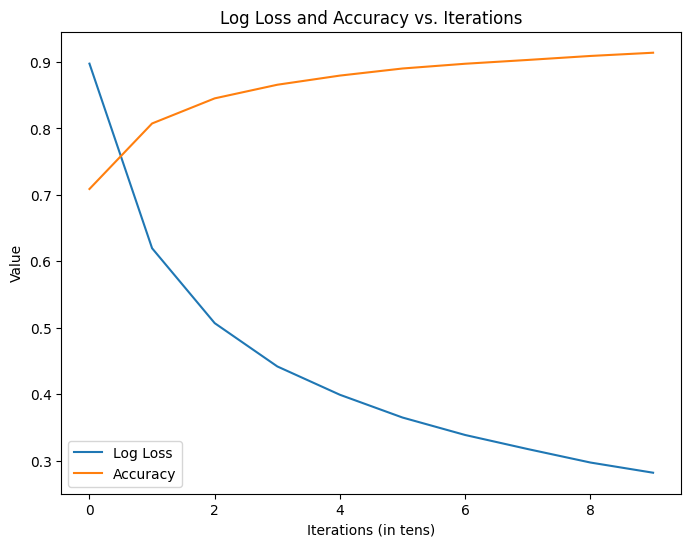

In [26]:
layer_sizes = [X_train.shape[0], 123, 64, 32, 10]  
parameters = gradient_descent(X_train, Y_train, layer_sizes, 0.15, 500)

In [ ]:
with open("trained_params.pkl", "wb") as dump_file:
    pickle.dump(parameters, dump_file)

with open("trained_params.pkl", "rb") as dump_file:
    params = pickle.load(dump_file)

def show_prediction(index, X, Y, parameters):
    vect_X = X[:, index, None]
    prediction = make_predictions(vect_X, parameters)
    label = Y[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = vect_X.reshape((WIDTH, HEIGHT)) * SCALE_FACTOR

    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.axis('off')
    plt.show()

for pred in range(1, 10):
    index = random.randint(0, len(Y_test))
    show_prediction(index, X_test, Y_test, params)


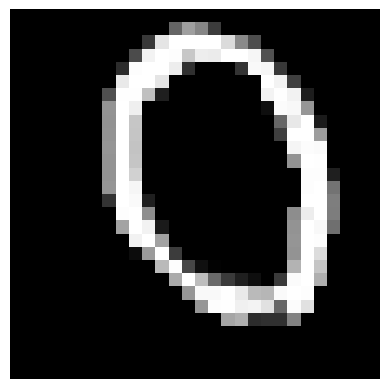

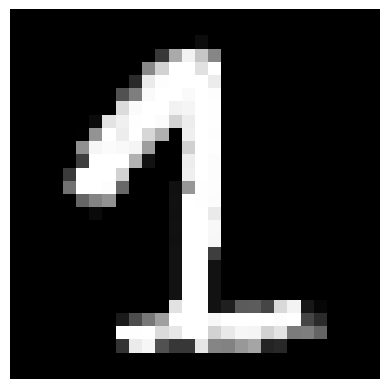

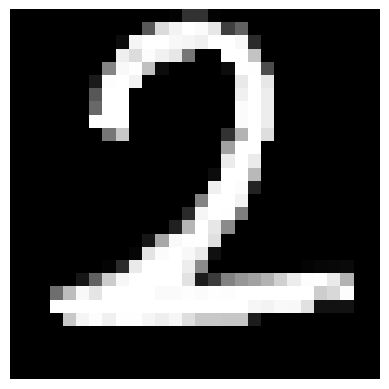

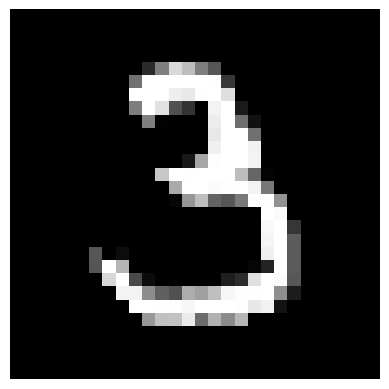

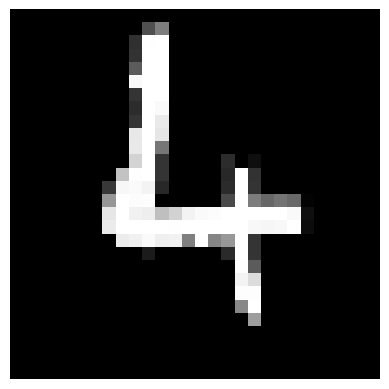

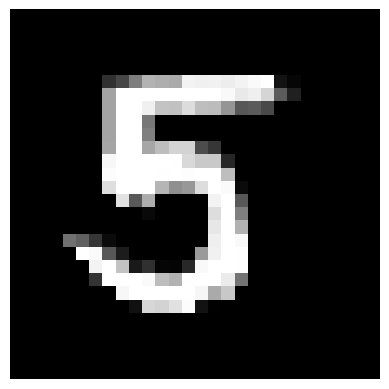

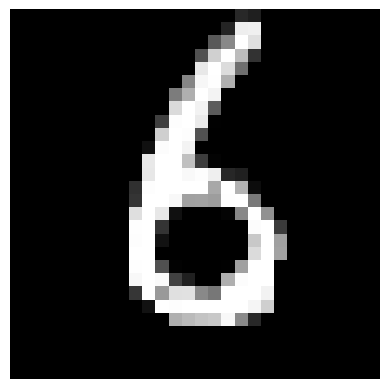

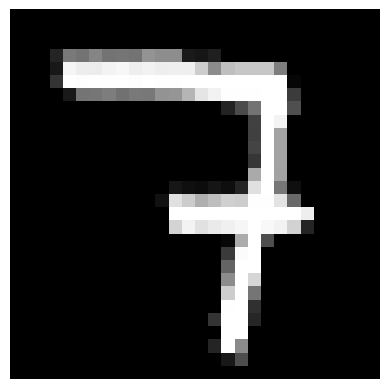

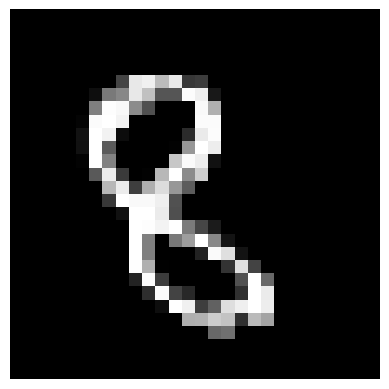

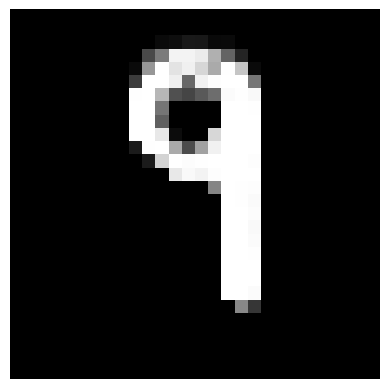

In [142]:
images = os.listdir('C:\\Users\\marti\\OneDrive\\Bureau\\vscode\\machine_learning\\mnist\\images_mnist')
label_images = []
plt_images = []

for image in images:
    path = 'C:\\Users\\marti\\OneDrive\\Bureau\\vscode\\machine_learning\\mnist\\images_mnist\\{}'.format(image)

    test_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(test_image, cmap='gray')

    test_image = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)

    plt.imshow(test_image, cmap='gray')
    plt.axis('off')
    plt.show()

    test_image = test_image.astype('float64')
    test_image /= 255

    test_image_fl = test_image.flatten()

    plt_images.append(test_image)
    label_images.append(test_image_fl) 

In [143]:
label_images = np.array(label_images)
label_images = label_images.reshape(label_images.shape[0], WIDTH*HEIGHT).T

In [133]:
y_label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Prediction:  [5]
Label:  0


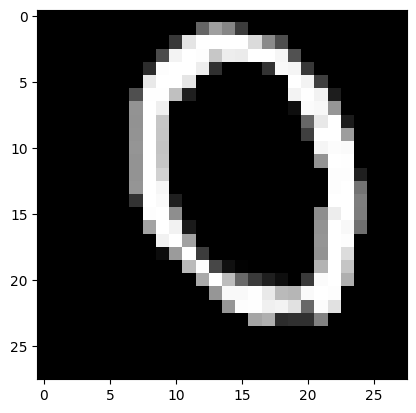

Prediction:  [8]
Label:  1


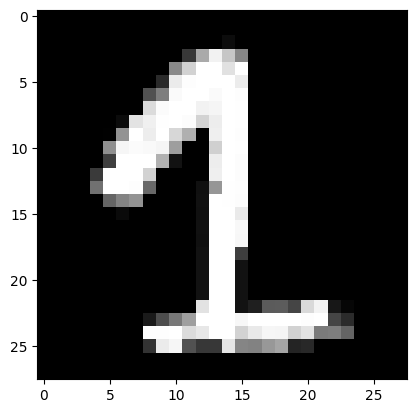

Prediction:  [2]
Label:  2


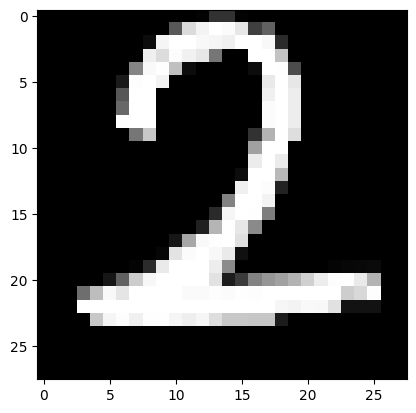

Prediction:  [3]
Label:  3


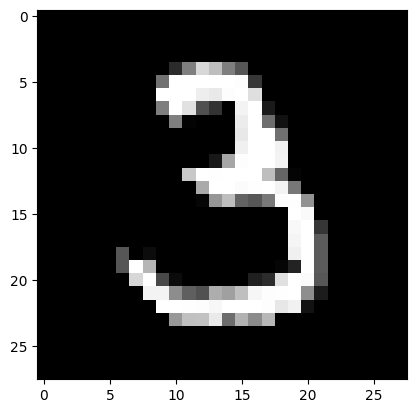

Prediction:  [4]
Label:  4


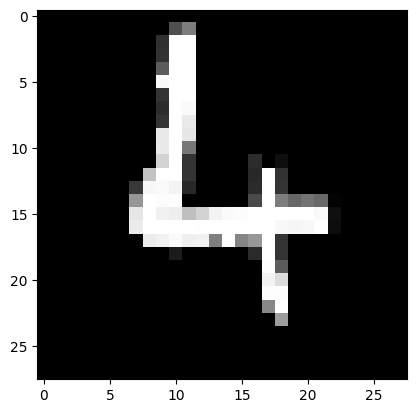

Prediction:  [5]
Label:  5


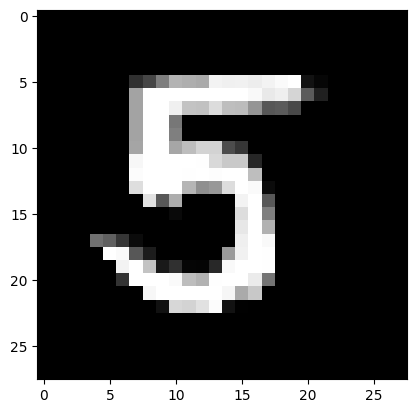

Prediction:  [1]
Label:  6


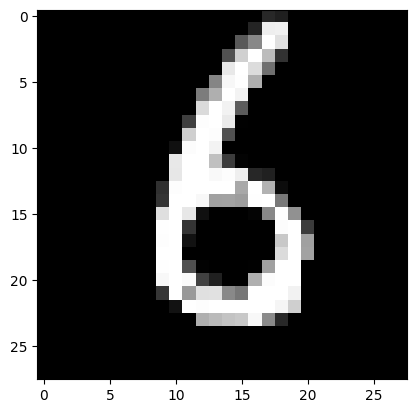

Prediction:  [2]
Label:  7


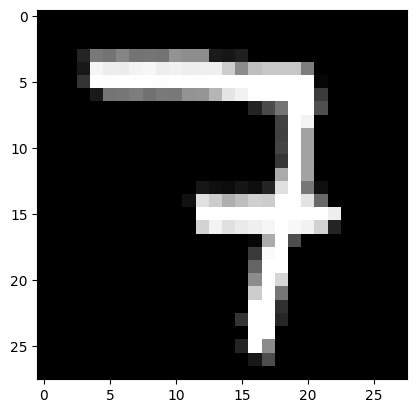

Prediction:  [5]
Label:  8


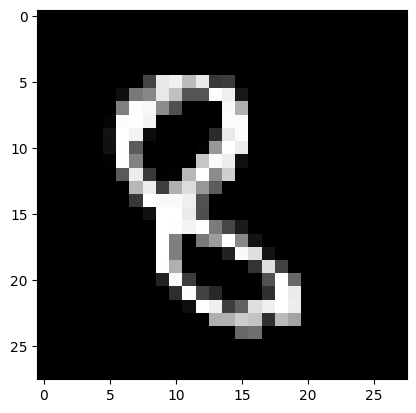

Prediction:  [3]
Label:  9


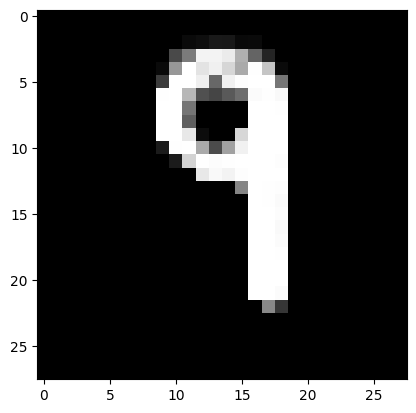

In [144]:
for index in range(10):
    show_prediction(index, label_images, y_label, params)